In [1]:
# MIMIC-IV AKI Prediction: Data Preprocessing & Feature Engineering
#
# Purpose: Prepare extracted features for supervised multi-label classification
# Input: output/aki_prediction_features.csv (from extraction script)
# Output: Train/Val/Test splits ready for modeling
#
# Steps:
# 1. Load and inspect data
# 2. Handle missing data systematically
# 3. Feature engineering
# 4. Encode categorical variables
# 5. Feature selection
# 6. Train/Val/Test split (70/15/15)
# 7. Scaling and normalization
# 8. Save preprocessed datasets

# 1. Setup & Load Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
import joblib
import warnings
warnings.filterwarnings('ignore')

# Plotting setup
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

DATA_DIR = "./prediction_output/data"
RESULT_DIR = "./prediction_output/result"
print("✓ Libraries loaded")

print("LOADING EXTRACTED FEATURES")
print("="*60)

df = pd.read_csv(f"{DATA_DIR}/aki_prediction_features.csv", parse_dates=['aki_time'])

print(f"\n📊 Dataset Overview:")
print(f"   Rows: {len(df):,}")
print(f"   Columns: {df.shape[1]}")
print(f"   Memory: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

# Check outcome distributions
target_cols = ['severe_aki', 'progression', 'mortality', 'prolonged_icu']
print(f"\n🎯 Outcome Distributions:")
for col in target_cols:
    count = df[col].sum()
    pct = df[col].mean() * 100
    print(f"   {col:20s}: {count:5d} ({pct:5.1f}%)")

✓ Libraries loaded
LOADING EXTRACTED FEATURES

📊 Dataset Overview:
   Rows: 15,394
   Columns: 76
   Memory: 13.6 MB

🎯 Outcome Distributions:
   severe_aki          :  6933 ( 45.0%)
   progression         :  5159 ( 33.5%)
   mortality           :  4299 ( 27.9%)
   prolonged_icu       :  4546 ( 29.5%)


# 2. Missing Data Analysis

Missing Data Analysis

Features by missingness category:
  Complete (0% missing):        24
  Low (<10% missing):           8
  Medium (10-30% missing):      30
  High (30-50% missing):        7
  Very high (>50% missing):     7

Top 20 features with missing data:
         feature  missing_pct  missing_count
0          max_k    63.583214              0
1          min_k    63.583214              0
2         mean_k    63.583214              0
3      mean_bili    54.254905              0
4       max_bili    54.254905              0
5       min_bili    54.254905              0
6        std_map    50.214369              0
7    shock_index    49.447837              0
8        min_map    49.395869              0
9        max_map    49.395869              0
10      mean_map    49.395869              0
11   max_lactate    35.292971              0
12   min_lactate    35.292971              0
13  mean_lactate    35.292971              0
14        min_ph    26.549305              0
15        max_p

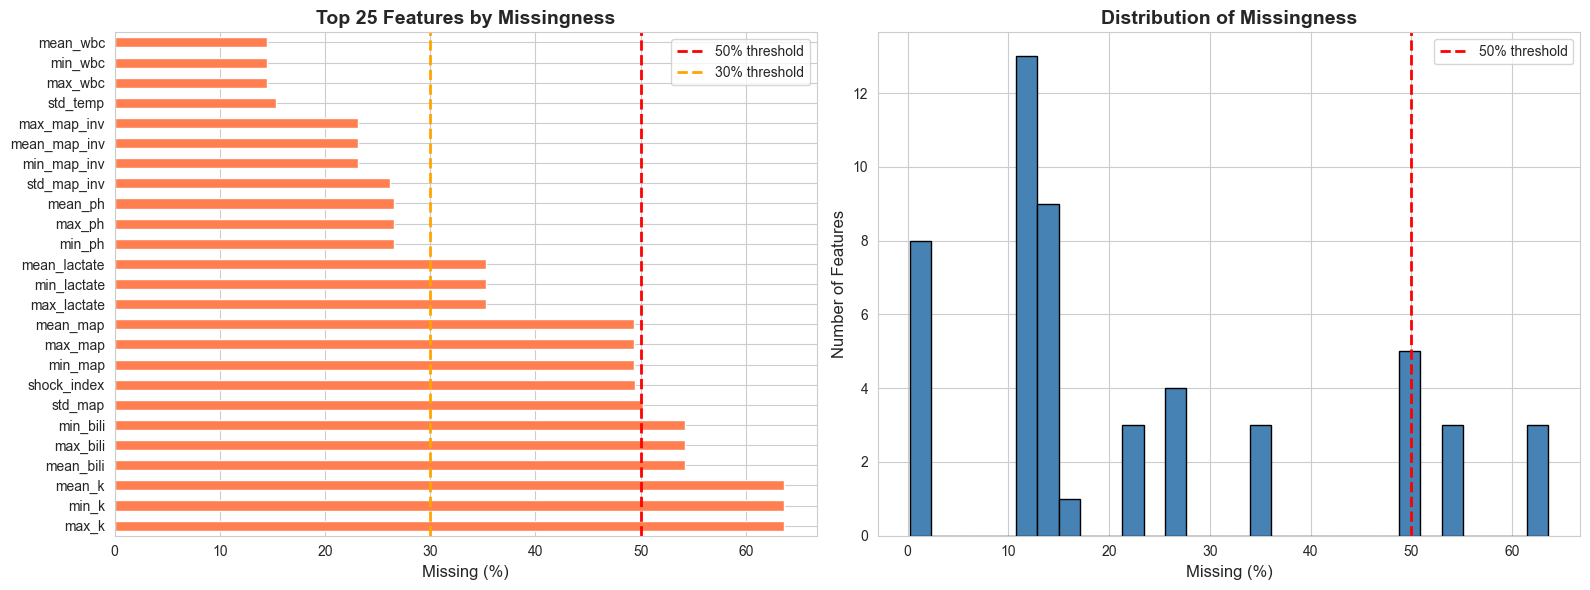

✓ Figure saved to ./prediction_output/result/prediction_missingness_analysis.png


In [3]:
print("Missing Data Analysis")
print("="*60)

# Calculate missingness
missing = (df.isnull().sum() / len(df) * 100).sort_values(ascending=False)
missing_df = pd.DataFrame({
    'feature': missing.index,
    'missing_pct': missing.values,
    'missing_count': df.isnull().sum().values
})

print("\nFeatures by missingness category:")
print(f"  Complete (0% missing):        {(missing == 0).sum()}")
print(f"  Low (<10% missing):           {((missing > 0) & (missing < 10)).sum()}")
print(f"  Medium (10-30% missing):      {(missing.between(10, 30)).sum()}")
print(f"  High (30-50% missing):        {(missing.between(30, 50)).sum()}")
print(f"  Very high (>50% missing):     {(missing > 50).sum()}")

print("\nTop 20 features with missing data:")
print(missing_df.head(20))

# Visualize missingness
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot
top_missing = missing[missing > 0].head(25)
top_missing.plot(kind='barh', ax=axes[0], color='coral')
axes[0].set_xlabel('Missing (%)', fontsize=12)
axes[0].set_title('Top 25 Features by Missingness', fontsize=14, fontweight='bold')
axes[0].axvline(50, color='red', linestyle='--', linewidth=2, label='50% threshold')
axes[0].axvline(30, color='orange', linestyle='--', linewidth=2, label='30% threshold')
axes[0].legend()

# Histogram
missing[missing > 0].plot(kind='hist', bins=30, ax=axes[1], color='steelblue', edgecolor='black')
axes[1].set_xlabel('Missing (%)', fontsize=12)
axes[1].set_ylabel('Number of Features', fontsize=12)
axes[1].set_title('Distribution of Missingness', fontsize=14, fontweight='bold')
axes[1].axvline(50, color='red', linestyle='--', linewidth=2, label='50% threshold')
axes[1].legend()

plt.tight_layout()
plt.savefig(f"{RESULT_DIR}/prediction_missingness_analysis.png", dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Figure saved to {RESULT_DIR}/prediction_missingness_analysis.png")

# 3. Handle Duplicate Features (potassium)

In [4]:
print("Handle Duplicate Features (potassium)")
print("="*60)

k_cols = [col for col in df.columns if 'k' in col.lower() and any(x in col for x in ['mean_', 'max_', 'min_'])]
k_cols = [col for col in k_cols if col not in ['shock_index']]

if k_cols:
    print(f"\nPotassium columns found: {k_cols}")
    for col in k_cols:
        missing_pct = df[col].isnull().sum() / len(df) * 100
        print(f"  {col}: {missing_pct:.1f}% missing")
    
    k_to_drop = [col for col in k_cols if df[col].isnull().sum() / len(df) * 100 > 70]
    
    if k_to_drop:
        print(f"\n  → Dropping high-missing potassium columns: {k_to_drop}")
        df = df.drop(columns=k_to_drop)
        print(f"  ✓ Dropped {len(k_to_drop)} columns")
else:
    print("No duplicate potassium columns found")

print(f"\n✓ Dataset shape after duplicate removal: {df.shape}")

Handle Duplicate Features (potassium)

Potassium columns found: ['mean_k', 'min_k', 'max_k']
  mean_k: 63.6% missing
  min_k: 63.6% missing
  max_k: 63.6% missing

✓ Dataset shape after duplicate removal: (15394, 76)


# 4. Create Missingness Indicator Features

In [5]:
print("Create Missingness Indicator Features")
print("="*60)

missingness_indicators = {
    'has_map_monitoring': 'mean_map',
    'has_lactate': 'max_lactate', 
    'has_bilirubin': 'max_bili',
    'has_abg': 'mean_ph',
    'has_hemoglobin': 'min_hgb',
    'has_platelet': 'min_plt'
}

indicators_created = []
for indicator_name, source_col in missingness_indicators.items():
    if source_col in df.columns:
        df[indicator_name] = (~df[source_col].isna()).astype(int)
        indicators_created.append(indicator_name)
        pct_measured = df[indicator_name].mean() * 100
        print(f"  ✓ {indicator_name}: {pct_measured:.1f}% of patients")

print(f"\n✓ Created {len(indicators_created)} missingness indicators")

Create Missingness Indicator Features
  ✓ has_map_monitoring: 50.6% of patients
  ✓ has_lactate: 64.7% of patients
  ✓ has_bilirubin: 45.7% of patients
  ✓ has_abg: 73.5% of patients
  ✓ has_hemoglobin: 86.0% of patients
  ✓ has_platelet: 85.8% of patients

✓ Created 6 missingness indicators


# 5. Feature Engineering

In [6]:
print("Feature Engineering")
print("="*60)

print("\nCreating derived features...")

# 1. AKI severity metrics
if 'cr_fold_change' not in df.columns and 'aki_cr' in df.columns and 'baseline_cr' in df.columns:
    df['cr_fold_change'] = df['aki_cr'] / df['baseline_cr']
    print("  ✓ cr_fold_change")

if 'cr_change_pct' not in df.columns and 'aki_cr' in df.columns and 'baseline_cr' in df.columns:
    df['cr_change_pct'] = (df['aki_cr'] - df['baseline_cr']) / df['baseline_cr'] * 100
    print("  ✓ cr_change_pct")

# 2. Shock index
if 'shock_index' not in df.columns and 'mean_hr' in df.columns and 'mean_map' in df.columns:
    df['shock_index'] = df['mean_hr'] / df['mean_map'].replace(0, np.nan)
    print("  ✓ shock_index")

# 3. BUN/Cr ratio
if 'bun_cr_ratio' not in df.columns and 'mean_bun' in df.columns and 'mean_cr' in df.columns:
    df['bun_cr_ratio'] = df['mean_bun'] / df['mean_cr'].replace(0, np.nan)
    print("  ✓ bun_cr_ratio")

# 4. Comorbidity burden score
comorbidity_cols = ['chf', 'hypertension', 'diabetes', 'ckd', 'liver_disease', 'copd', 'malignancy']
comorbidity_cols = [col for col in comorbidity_cols if col in df.columns]
if comorbidity_cols:
    df['comorbidity_count'] = df[comorbidity_cols].sum(axis=1)
    print("  ✓ comorbidity_count")

# 5. Age categories
if 'age' in df.columns:
    df['age_category'] = pd.cut(df['age'], bins=[0, 40, 60, 75, 120], 
                                  labels=['young', 'middle', 'elderly', 'very_elderly'])
    print("  ✓ age_category")

# 6. MAP adequacy
if 'mean_map' in df.columns:
    df['hypotensive'] = (df['mean_map'] < 65).astype(int)
    print("  ✓ hypotensive indicator")

# 7. Thrombocytopenia
if 'min_plt' in df.columns:
    df['thrombocytopenia'] = (df['min_plt'] < 150).astype(int)
    print("  ✓ thrombocytopenia indicator")

print(f"\n✓ Dataset shape after feature engineering: {df.shape}")

Feature Engineering

Creating derived features...
  ✓ comorbidity_count
  ✓ age_category
  ✓ hypotensive indicator
  ✓ thrombocytopenia indicator

✓ Dataset shape after feature engineering: (15394, 86)


# 6. Feature Categorization

In [7]:
print("Feature Categorization")
print("="*60)

# Identifiers and targets
identifier_cols = ['stay_id', 'aki_time']
# AKI stage not used as target for multi-label (use the 4 binary outcomes instead)
info_cols = ['aki_stage', 'baseline_cr', 'aki_cr']

# Categorical features
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_cols = [col for col in categorical_cols if col not in identifier_cols]

# Numeric features (excluding identifiers, targets, and info)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [col for col in numeric_cols if col not in identifier_cols + target_cols + info_cols]

# Binary features
binary_cols = [col for col in numeric_cols if df[col].dropna().isin([0, 1]).all()]

# Continuous features
continuous_cols = [col for col in numeric_cols if col not in binary_cols]

print(f"\nFeature types:")
print(f"  Identifiers:          {len(identifier_cols)}")
print(f"  Target variables:     {len(target_cols)}")
print(f"  Info columns:         {len(info_cols)}")
print(f"  Categorical:          {len(categorical_cols)}")
print(f"  Binary:               {len(binary_cols)}")
print(f"  Continuous:           {len(continuous_cols)}")

print(f"\nCategorical features: {categorical_cols}")
print(f"Binary features (first 10): {binary_cols[:10]}")

Feature Categorization

Feature types:
  Identifiers:          2
  Target variables:     4
  Info columns:         3
  Categorical:          6
  Binary:               15
  Continuous:           56

Categorical features: ['first_careunit', 'gender', 'race', 'admission_type', 'admission_location', 'age_category']
Binary features (first 10): ['chf', 'hypertension', 'diabetes', 'ckd', 'liver_disease', 'copd', 'malignancy', 'has_map_monitoring', 'has_lactate', 'has_bilirubin']


# 7. Missing Data Imputation

In [8]:
print("Missing Data Imputation")
print("="*60)

# Separate by missingness level
missing_pcts = df[continuous_cols].isnull().sum() / len(df) * 100

low_missing_features = missing_pcts[missing_pcts < 10].index.tolist()
med_missing_features = missing_pcts[missing_pcts.between(10, 30)].index.tolist()
high_missing_features = missing_pcts[missing_pcts.between(30, 50)].index.tolist()
very_high_missing = missing_pcts[missing_pcts >= 50].index.tolist()

print(f"\nContinuous features by missingness:")
print(f"  Low (<10%):          {len(low_missing_features)}")
print(f"  Medium (10-30%):     {len(med_missing_features)}")
print(f"  High (30-50%):       {len(high_missing_features)}")
print(f"  Very high (≥50%):    {len(very_high_missing)}")

# Drop features with >50% missing
if very_high_missing:
    print(f"\n  → Dropping {len(very_high_missing)} features with >50% missing:")
    print(f"     {very_high_missing}")
    df = df.drop(columns=very_high_missing)
    continuous_cols = [col for col in continuous_cols if col not in very_high_missing]

# Median imputation for low-medium missing (<30%)
low_med_features = [col for col in continuous_cols if col in low_missing_features + med_missing_features]
if low_med_features:
    print(f"\n  → Median imputation for {len(low_med_features)} features (<30% missing)")
    imputer_median = SimpleImputer(strategy='median')
    df[low_med_features] = imputer_median.fit_transform(df[low_med_features])
    print(f"     ✓ Imputed")

# KNN imputation for high missing (30-50%)
high_features = [col for col in continuous_cols if col in high_missing_features]
if high_features:
    print(f"\n  → KNN imputation for {len(high_features)} features (30-50% missing)")
    print(f"     Features: {high_features}")
    
    predictor_cols = low_med_features[:20]
    knn_features = predictor_cols + high_features
    
    imputer_knn = KNNImputer(n_neighbors=5, weights='distance')
    df[knn_features] = imputer_knn.fit_transform(df[knn_features])
    print(f"     ✓ Imputed using {len(predictor_cols)} predictor features")

# Handle any remaining missing
remaining_missing = df[continuous_cols].isnull().sum().sum()
if remaining_missing > 0:
    print(f"\n  ⚠ Warning: {remaining_missing} missing values remain")
    print(f"     Applying median imputation to remaining...")
    imputer_final = SimpleImputer(strategy='median')
    df[continuous_cols] = imputer_final.fit_transform(df[continuous_cols])

print(f"\n✓ Missing data imputation complete")
print(f"  Remaining missing in continuous: {df[continuous_cols].isnull().sum().sum()}")

Missing Data Imputation

Continuous features by missingness:
  Low (<10%):          12
  Medium (10-30%):     30
  High (30-50%):       7
  Very high (≥50%):    7

  → Dropping 7 features with >50% missing:
     ['std_map', 'mean_bili', 'mean_k', 'min_bili', 'min_k', 'max_bili', 'max_k']

  → Median imputation for 42 features (<30% missing)
     ✓ Imputed

  → KNN imputation for 7 features (30-50% missing)
     Features: ['mean_map', 'min_map', 'max_map', 'mean_lactate', 'min_lactate', 'max_lactate', 'shock_index']
     ✓ Imputed using 20 predictor features

✓ Missing data imputation complete
  Remaining missing in continuous: 0


# 8. Encode Categorical Variables

In [9]:
print("Encode Categorical Variables")
print("="*60)

if categorical_cols:
    print(f"\nOne-hot encoding {len(categorical_cols)} categorical features:")
    
    for col in categorical_cols:
        n_categories = df[col].nunique()
        print(f"  {col}: {n_categories} categories")
    
    df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True, dtype=int)
    new_dummy_cols = [col for col in df_encoded.columns if col not in df.columns]
    
    print(f"\n  ✓ Created {len(new_dummy_cols)} dummy variables")
    print(f"  ✓ Dataset shape: {df_encoded.shape}")
    
    df = df_encoded
else:
    print("No categorical variables to encode")


# shorten columns names
careunit_map = {
    "first_careunit_Coronary Care Unit (CCU)": "ICU_CCU",
    "first_careunit_Intensive Care Unit (ICU)": "ICU_ICU",
    "first_careunit_Medical Intensive Care Unit (MICU)": "ICU_MICU",
    "first_careunit_Medical/Surgical Intensive Care Unit (MICU/SICU)": "ICU_MICU_SICU",
    "first_careunit_Medicine": "ICU_MED",
    "first_careunit_Medicine/Cardiology Intermediate": "ICU_MED_CARD_INT",
    "first_careunit_Neuro Intermediate": "ICU_NEURO_INT",
    "first_careunit_Neuro Stepdown": "ICU_NEURO_SD",
    "first_careunit_Neuro Surgical Intensive Care Unit (Neuro SICU)": "ICU_NEURO_SICU",
    "first_careunit_PACU": "ICU_PACU",
    "first_careunit_Surgery/Trauma": "ICU_SURG_TRAUMA",
    "first_careunit_Surgery/Vascular/Intermediate": "ICU_SURG_VASC_INT",
    "first_careunit_Surgical Intensive Care Unit (SICU)": "ICU_SICU",
    "first_careunit_Trauma SICU (TSICU)": "ICU_TSICU",
}

df = df.rename(columns=careunit_map)

Encode Categorical Variables

One-hot encoding 6 categorical features:
  first_careunit: 15 categories
  gender: 2 categories
  race: 33 categories
  admission_type: 8 categories
  admission_location: 10 categories
  age_category: 4 categories

  ✓ Created 66 dummy variables
  ✓ Dataset shape: (15394, 139)


# 9. Feature Selection

In [10]:
print("Feature Selection")
print("="*60)

# Identify features for modeling
all_feature_cols = [col for col in df.columns if col not in identifier_cols + target_cols + info_cols]

print(f"\nTotal features before selection: {len(all_feature_cols)}")

# Remove zero-variance features
print("\n  Checking for zero-variance features...")
variance_filter = VarianceThreshold(threshold=0.0)
df_variance = df[all_feature_cols].copy()

variance_filter.fit(df_variance)
zero_var_mask = variance_filter.get_support()
zero_var_features = df_variance.columns[~zero_var_mask].tolist()

if zero_var_features:
    print(f"  → Removing {len(zero_var_features)} zero-variance features:")
    print(f"     {zero_var_features}")
    all_feature_cols = [col for col in all_feature_cols if col not in zero_var_features]
    df = df.drop(columns=zero_var_features)
else:
    print("  ✓ No zero-variance features found")

# Remove highly correlated features (r > 0.95)
print("\n  Checking for highly correlated features (r > 0.95)...")
numeric_features = [col for col in all_feature_cols if col in df.select_dtypes(include=[np.number]).columns]

if len(numeric_features) > 1:
    corr_matrix = df[numeric_features].corr().abs()
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    high_corr_features = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
    
    if high_corr_features:
        print(f"  → Removing {len(high_corr_features)} highly correlated features:")
        for feat in high_corr_features:
            corr_pairs = upper_tri[feat][upper_tri[feat] > 0.95]
            print(f"     {feat}: correlated with {corr_pairs.index.tolist()}")
        
        all_feature_cols = [col for col in all_feature_cols if col not in high_corr_features]
        df = df.drop(columns=high_corr_features)
    else:
        print("  ✓ No highly correlated features found")

print(f"\n✓ Final features after selection: {len(all_feature_cols)}")

Feature Selection

Total features before selection: 130

  Checking for zero-variance features...
  ✓ No zero-variance features found

  Checking for highly correlated features (r > 0.95)...
  → Removing 20 highly correlated features:
     max_hr: correlated with ['mean_hr']
     max_map_inv: correlated with ['mean_map_inv']
     std_hr: correlated with ['mean_hr', 'max_hr']
     std_map_inv: correlated with ['mean_map_inv', 'max_map_inv']
     std_rr: correlated with ['max_rr']
     std_temp: correlated with ['max_temp']
     min_bun: correlated with ['mean_bun']
     min_cr: correlated with ['mean_cr']
     min_hco3: correlated with ['mean_hco3']
     min_plt: correlated with ['mean_plt']
     min_wbc: correlated with ['mean_wbc']
     max_bun: correlated with ['mean_bun', 'min_bun']
     max_cr: correlated with ['mean_cr']
     max_hco3: correlated with ['mean_hco3']
     max_hgb: correlated with ['mean_hgb']
     max_plt: correlated with ['mean_plt']
     max_wbc: correlated with [

# 10. Train/Val/Test Split (70/15/15)

In [11]:
print("Train/Val/Test Split (70/15/15)")
print("="*60)

# Prepare X and y
X = df[all_feature_cols].copy()
y = df[target_cols].copy()
identifiers = df[identifier_cols + info_cols].copy()

print(f"\nDataset before split:")
print(f"  Total samples: {len(X):,}")
print(f"  Features: {X.shape[1]}")
print(f"  Targets: {y.shape[1]}")

# First split: 70% train, 30% temp
# Stratify on primary outcome (severe_aki)
X_train, X_temp, y_train, y_temp, id_train, id_temp = train_test_split(
    X, y, identifiers,
    test_size=0.30,
    random_state=42,
    stratify=y['severe_aki']
)

# Second split: 15% val, 15% test (50/50 of the 30%)
X_val, X_test, y_val, y_test, id_val, id_test = train_test_split(
    X_temp, y_temp, id_temp,
    test_size=0.50,
    random_state=42,
    stratify=y_temp['severe_aki']
)

print(f"\n✓ Split complete:")
print(f"  Train: {len(X_train):,} ({len(X_train)/len(X)*100:.1f}%)")
print(f"  Val:   {len(X_val):,} ({len(X_val)/len(X)*100:.1f}%)")
print(f"  Test:  {len(X_test):,} ({len(X_test)/len(X)*100:.1f}%)")

# Verify stratification
print(f"\n✓ Outcome distributions (severe_aki):")
print(f"  Train: {y_train['severe_aki'].mean()*100:.1f}%")
print(f"  Val:   {y_val['severe_aki'].mean()*100:.1f}%")
print(f"  Test:  {y_test['severe_aki'].mean()*100:.1f}%")

Train/Val/Test Split (70/15/15)

Dataset before split:
  Total samples: 15,394
  Features: 110
  Targets: 4

✓ Split complete:
  Train: 10,775 (70.0%)
  Val:   2,309 (15.0%)
  Test:  2,310 (15.0%)

✓ Outcome distributions (severe_aki):
  Train: 45.0%
  Val:   45.0%
  Test:  45.0%


# 11. Feature Scaling (FIT ON TRAIN ONLY)

In [16]:
print("Feature Scaling")
print("="*60)

# Update binary_cols after feature selection
binary_cols = [col for col in binary_cols if col in all_feature_cols]

# Separate features that need scaling
features_to_scale = [col for col in all_feature_cols if col not in binary_cols]

print(f"\nFeatures to scale (continuous): {len(features_to_scale)}")
print(f"Features to keep as-is (binary): {len(binary_cols)}")

if features_to_scale:
    # Fit scaler on training data ONLY
    scaler = RobustScaler()
    
    # Create copies
    X_train_scaled = X_train.copy()
    X_val_scaled = X_val.copy()
    X_test_scaled = X_test.copy()
    
    # Fit on train, transform all
    X_train_scaled[features_to_scale] = scaler.fit_transform(X_train[features_to_scale])
    X_val_scaled[features_to_scale] = scaler.transform(X_val[features_to_scale])
    X_test_scaled[features_to_scale] = scaler.transform(X_test[features_to_scale])
    
    print("\n  ✓ Applied RobustScaler to continuous features")
    print("     Fitted on TRAIN set only (prevents data leakage)")
    
    # Save the scaler
    joblib.dump(scaler, f"{DATA_DIR}/prediction_scaler.pkl")
    print(f"     ✓ Saved scaler to {DATA_DIR}/prediction_scaler.pkl")
else:
    X_train_scaled = X_train.copy()
    X_val_scaled = X_val.copy()
    X_test_scaled = X_test.copy()
    print("\n  No continuous features to scale")

Feature Scaling

Features to scale (continuous): 96
Features to keep as-is (binary): 14

  ✓ Applied RobustScaler to continuous features
     Fitted on TRAIN set only (prevents data leakage)
     ✓ Saved scaler to ./prediction_output/data/prediction_scaler.pkl


# 12. Dataset Summary

In [13]:
print("Dataset Summary")
print("="*60)

print(f"\nDataset dimensions:")
print(f"  Train samples:         {len(X_train_scaled):,}")
print(f"  Val samples:           {len(X_val_scaled):,}")
print(f"  Test samples:          {len(X_test_scaled):,}")
print(f"  Features:              {X_train_scaled.shape[1]}")
print(f"  Target variables:      {y_train.shape[1]}")

print(f"\nFeature breakdown:")
print(f"  Binary features:       {len(binary_cols)}")
print(f"  Continuous features:   {len(features_to_scale)}")

print(f"\nData quality:")
print(f"  Missing values (train): {X_train_scaled.isnull().sum().sum()}")
print(f"  Infinite values (train): {np.isinf(X_train_scaled.select_dtypes(include=[np.number])).sum().sum()}")

print(f"\n📋 Multi-label targets:")
for col in target_cols:
    train_pct = y_train[col].mean() * 100
    val_pct = y_val[col].mean() * 100
    test_pct = y_test[col].mean() * 100
    print(f"  {col:20s}: Train={train_pct:5.1f}%  Val={val_pct:5.1f}%  Test={test_pct:5.1f}%")


Dataset Summary

Dataset dimensions:
  Train samples:         10,775
  Val samples:           2,309
  Test samples:          2,310
  Features:              110
  Target variables:      4

Feature breakdown:
  Binary features:       14
  Continuous features:   96

Data quality:
  Missing values (train): 0
  Infinite values (train): 0

📋 Multi-label targets:
  severe_aki          : Train= 45.0%  Val= 45.0%  Test= 45.0%
  progression         : Train= 33.5%  Val= 34.5%  Test= 32.6%
  mortality           : Train= 28.2%  Val= 27.2%  Test= 27.2%
  prolonged_icu       : Train= 29.4%  Val= 29.6%  Test= 29.9%


# 13. Save Data

In [14]:
print("Saving Data")
print("="*60)

# Save feature sets
X_train_scaled.to_csv(f"{DATA_DIR}/X_train.csv", index=False)
X_val_scaled.to_csv(f"{DATA_DIR}/X_val.csv", index=False)
X_test_scaled.to_csv(f"{DATA_DIR}/X_test.csv", index=False)
print(f"✓ Saved X_train.csv, X_val.csv, X_test.csv")

# Save target sets
y_train.to_csv(f"{DATA_DIR}/y_train.csv", index=False)
y_val.to_csv(f"{DATA_DIR}/y_val.csv", index=False)
y_test.to_csv(f"{DATA_DIR}/y_test.csv", index=False)
print(f"✓ Saved y_train.csv, y_val.csv, y_test.csv")

# Save identifiers
id_train.to_csv(f"{DATA_DIR}/id_train.csv", index=False)
id_val.to_csv(f"{DATA_DIR}/id_val.csv", index=False)
id_test.to_csv(f"{DATA_DIR}/id_test.csv", index=False)
print(f"✓ Saved id_train.csv, id_val.csv, id_test.csv")

# Save feature metadata
feature_metadata = pd.DataFrame({
    'feature': all_feature_cols,
    'type': ['binary' if col in binary_cols else 'continuous' for col in all_feature_cols]
})
feature_metadata.to_csv(f"{DATA_DIR}/prediction_feature_metadata.csv", index=False)
print(f"✓ Saved prediction_feature_metadata.csv")


Saving Data
✓ Saved X_train.csv, X_val.csv, X_test.csv
✓ Saved y_train.csv, y_val.csv, y_test.csv
✓ Saved id_train.csv, id_val.csv, id_test.csv
✓ Saved prediction_feature_metadata.csv


Final Visualizations


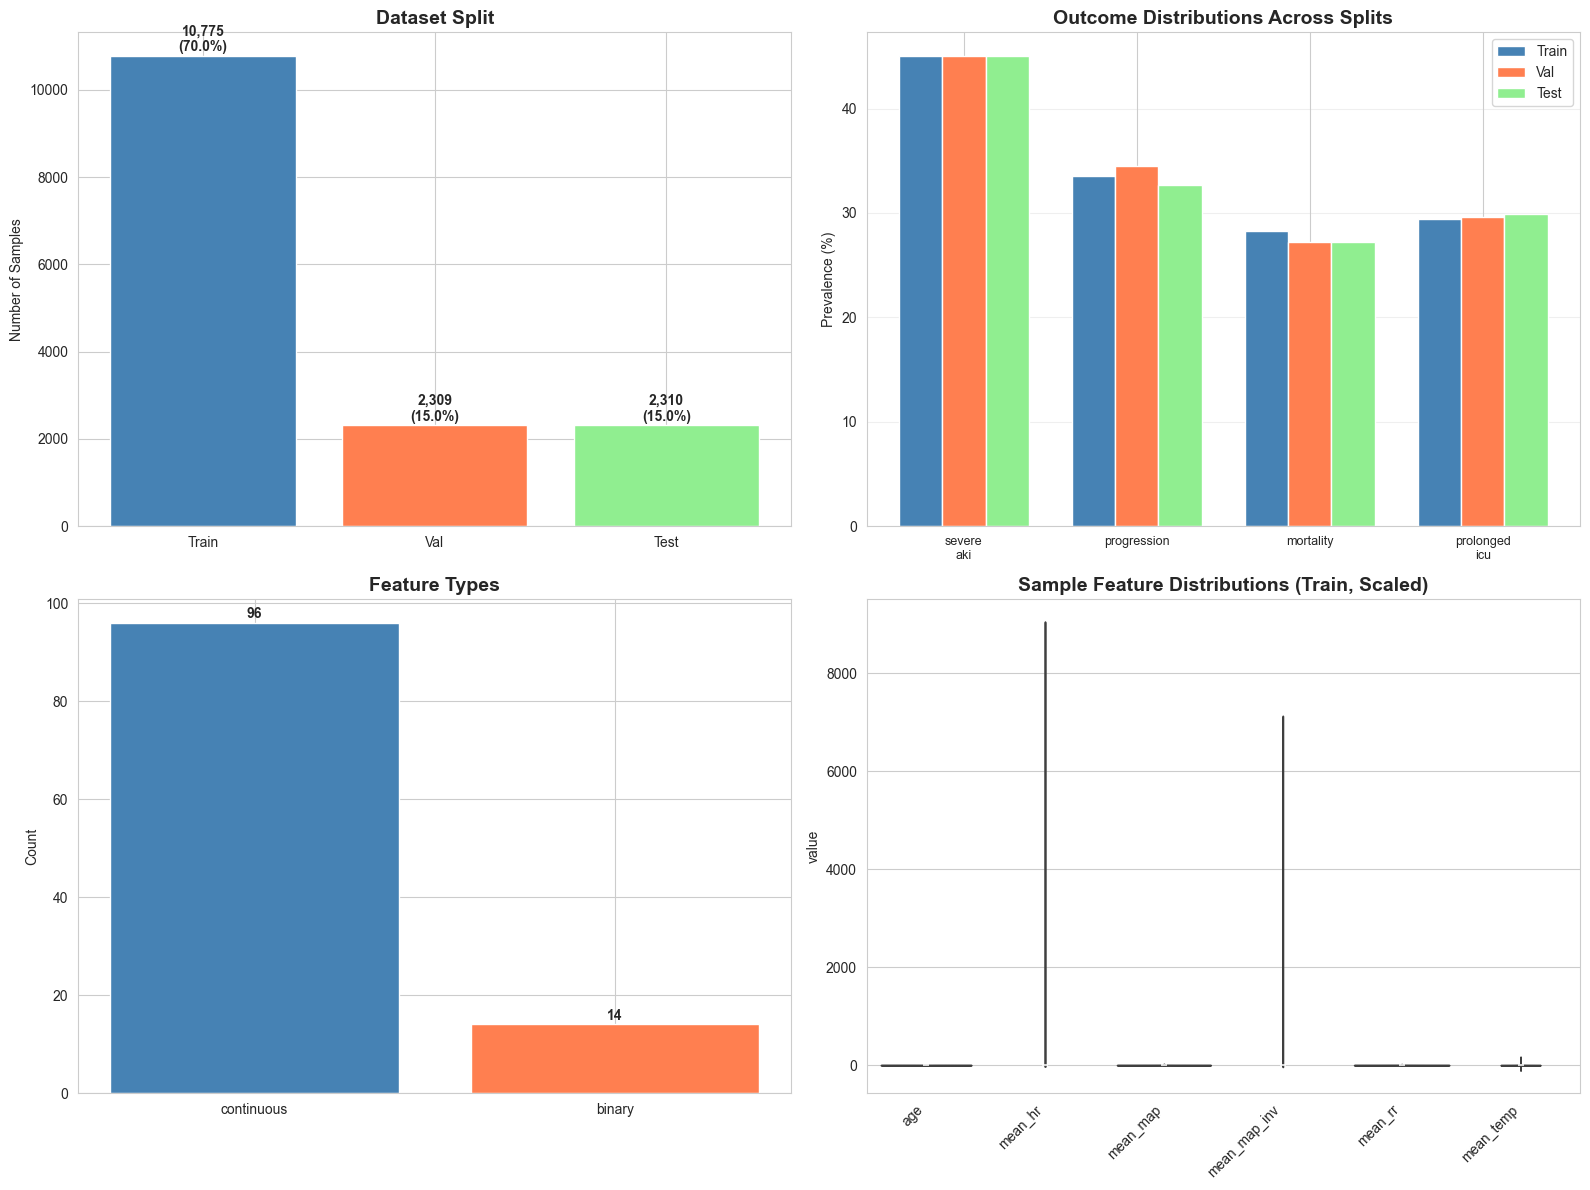

✓ Saved summary figure to ./prediction_output/result/prediction_preprocessing_summary.png


In [15]:
print("Final Visualizations")
print("="*60)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Sample sizes
sizes = pd.Series({
    'Train': len(X_train_scaled),
    'Val': len(X_val_scaled),
    'Test': len(X_test_scaled)
})
axes[0, 0].bar(sizes.index, sizes.values, color=['steelblue', 'coral', 'lightgreen'])
axes[0, 0].set_title('Dataset Split', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Number of Samples')
for i, v in enumerate(sizes.values):
    axes[0, 0].text(i, v + 100, f'{v:,}\n({v/len(X)*100:.1f}%)', ha='center', fontweight='bold')

# 2. Outcome distributions across splits
outcome_data = []
for outcome in target_cols:
    outcome_data.append({
        'Outcome': outcome.replace('_', ' ').title(),
        'Train': y_train[outcome].mean() * 100,
        'Val': y_val[outcome].mean() * 100,
        'Test': y_test[outcome].mean() * 100
    })
outcome_df = pd.DataFrame(outcome_data)
x = np.arange(len(target_cols))
width = 0.25
axes[0, 1].bar(x - width, outcome_df['Train'], width, label='Train', color='steelblue')
axes[0, 1].bar(x, outcome_df['Val'], width, label='Val', color='coral')
axes[0, 1].bar(x + width, outcome_df['Test'], width, label='Test', color='lightgreen')
axes[0, 1].set_title('Outcome Distributions Across Splits', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Prevalence (%)')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels([o.replace('_', '\n') for o in target_cols], fontsize=9)
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Feature types
feature_types = feature_metadata['type'].value_counts()
axes[1, 0].bar(feature_types.index, feature_types.values, color=['steelblue', 'coral'])
axes[1, 0].set_title('Feature Types', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('Count')
for i, v in enumerate(feature_types.values):
    axes[1, 0].text(i, v + 1, str(v), ha='center', fontweight='bold')

# 4. Sample feature distributions
continuous_sample = features_to_scale[:6] if len(features_to_scale) >= 6 else features_to_scale
if continuous_sample:
    sample_data = X_train_scaled[continuous_sample].melt()
    sns.violinplot(data=sample_data, x='variable', y='value', ax=axes[1, 1])
    axes[1, 1].set_title('Sample Feature Distributions (Train, Scaled)', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('')
    axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=45, ha='right')
else:
    axes[1, 1].text(0.5, 0.5, 'Only binary features', ha='center', va='center')
    axes[1, 1].set_title('Sample Feature Distributions', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(f"{RESULT_DIR}/prediction_preprocessing_summary.png", dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Saved summary figure to {RESULT_DIR}/prediction_preprocessing_summary.png")
